In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
import json
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow.keras as keras
import matplotlib.pyplot as plt

In [3]:
# path to json file that stores MFCCs and genre labels for each processed segment
DATA_PATH = "data_10segment.json"

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 128, 11, 64)       640       
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 64, 6, 64)         0         
_________________________________________________________________
batch_normalization_9 (Batch (None, 64, 6, 64)         256       
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 62, 4, 32)         18464     
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 31, 2, 32)         0         
_________________________________________________________________
batch_normalization_10 (Batc (None, 31, 2, 32)         128       
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 30, 1, 32)        

92/92 [==============================] - 4s 47ms/step - loss: 0.1387 - accuracy: 0.9554 - val_loss: 0.3669 - val_accuracy: 0.8770
Epoch 45/50
92/92 [==============================] - 4s 47ms/step - loss: 0.1573 - accuracy: 0.9469 - val_loss: 0.3459 - val_accuracy: 0.8784
Epoch 46/50
92/92 [==============================] - 5s 51ms/step - loss: 0.1331 - accuracy: 0.9576 - val_loss: 0.3656 - val_accuracy: 0.8811
Epoch 47/50
92/92 [==============================] - 4s 47ms/step - loss: 0.1440 - accuracy: 0.9494 - val_loss: 0.3407 - val_accuracy: 0.8907
Epoch 48/50
92/92 [==============================] - 4s 48ms/step - loss: 0.1268 - accuracy: 0.9596 - val_loss: 0.3983 - val_accuracy: 0.8811
Epoch 49/50
92/92 [==============================] - 4s 47ms/step - loss: 0.1263 - accuracy: 0.9599 - val_loss: 0.3586 - val_accuracy: 0.8825
Epoch 50/50
92/92 [==============================] - 4s 47ms/step - loss: 0.1208 - accuracy: 0.9601 - val_loss: 0.3518 - val_accuracy: 0.8934


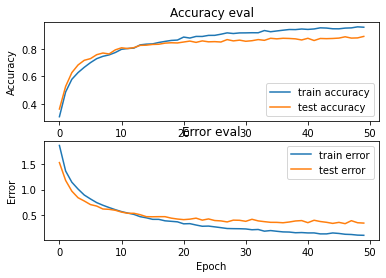

39/39 - 0s - loss: 0.4300 - accuracy: 0.8574

Test accuracy: 0.8573770523071289
Target: 3, Predicted label: [3]


In [88]:
def load_data(data_path):
    """Loads training dataset from json file.
        :param data_path (str): Path to json file containing data
        :return X (ndarray): Inputs
        :return y (ndarray): Targets
    """

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    return X, y


def plot_history(history):
    """Plots accuracy/loss for training/validation set as a function of the epochs
        :param history: Training history of model
        :return:
    """

    fig, axs = plt.subplots(2)

    # create accuracy sublpot
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")

    # create error sublpot
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()


def prepare_datasets(test_size, validation_size):
    """Loads data and splits it into train, validation and test sets.
    :param test_size (float): Value in [0, 1] indicating percentage of data set to allocate to test split
    :param validation_size (float): Value in [0, 1] indicating percentage of train set to allocate to validation split
    :return X_train (ndarray): Input training set
    :return X_validation (ndarray): Input validation set
    :return X_test (ndarray): Input test set
    :return y_train (ndarray): Target training set
    :return y_validation (ndarray): Target validation set
    :return y_test (ndarray): Target test set
    """

    # load data
    X, y = load_data(DATA_PATH)

    # create train, validation and test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=validation_size)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test


def build_model(input_shape):
    """Generates CNN model
    :param input_shape (tuple): Shape of input set
    :return model: CNN model
    """

    # build network topology
    model = keras.Sequential()

    # 1st conv layer
    model.add(keras.layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (3, 3), activation='relu'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(64, activation='relu'))
    model.add(keras.layers.Dropout(0.3))

    # output layer
    model.add(keras.layers.Dense(5, activation='softmax'))

    return model


def predict(model, X, y):
    """Predict a single sample using the trained model
    :param model: Trained classifier
    :param X: Input data
    :param y (int): Target
    """

    # add a dimension to input data for sample - model.predict() expects a 4d array in this case
    X = X[np.newaxis, ...] # array shape (1, 130, 13, 1)

    # perform prediction
    prediction = model.predict(X)

    # get index with max value
    predicted_index = np.argmax(prediction, axis=1)

    print("Target: {}, Predicted label: {}".format(y, predicted_index))


if __name__ == "__main__":

    # get train, validation, test splits
    X_train, X_validation, X_test, y_train, y_validation, y_test = prepare_datasets(0.25, 0.2)

    # create network
    input_shape = (X_train.shape[1], X_train.shape[2], 1)
    model = build_model(input_shape)

    # compile model
    optimiser = keras.optimizers.Adam(learning_rate=0.0001)
    model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

    model.summary()

    # train model
    history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=50)

    # plot accuracy/error for training and validation
    plot_history(history)

    # evaluate model on test set
    test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
    print('\nTest accuracy:', test_acc)

    # pick a sample to predict from the test set
    X_to_predict = X_test[100]
    y_to_predict = y_test[100]

    # predict sample
    predict(model, X_to_predict, y_to_predict)







In [84]:
import json
import os
import math
import librosa

DATASET_PATH = "data/test_data/maroon5/Maroon5_00109.wav"
JSON_PATH = "data_test2.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30 # measured in seconds
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=10):
    """Extracts MFCCs from music dataset and saves them into a json file along witgh genre labels.

        :param dataset_path (str): Path to dataset
        :param json_path (str): Path to json file used to save MFCCs
        :param num_mfcc (int): Number of coefficients to extract
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples
        :param hop_length (int): Sliding window for FFT. Measured in # of samples
        :param: num_segments (int): Number of segments we want to divide sample tracks into
        :return:
        """

    # dictionary to store mapping, labels, and MFCCs
    data = {
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)


    signal, sample_rate = librosa.load(dataset_path, sr=SAMPLE_RATE)

    # process all segments of audio file
    for d in range(num_segments):

        # calculate start and finish sample for current segment
        start = samples_per_segment * d
        finish = start + samples_per_segment

        # extract mfcc
        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
        mfcc = mfcc.T

        # store only mfcc feature with expected number of vectors
        if len(mfcc) == num_mfcc_vectors_per_segment:
            data["mfcc"].append(mfcc.tolist())
           
    return data

    # save MFCCs to json file
#     with open(json_path, "w") as fp:
#         json.dump(data, fp, indent=4)
        
        
if __name__ == "__main__":
    MFCC = save_mfcc(DATASET_PATH, JSON_PATH, num_segments=10)

In [85]:
# with open('data_test2.json', "r") as fp:
#         data = json.load(fp)

X = np.array(MFCC["mfcc"])


In [86]:
X = X[...,np.newaxis]
X.shape

(10, 130, 13, 1)

In [87]:
prediction = model.predict(X)

map = {0:"brunomars",
       1: "greenday",
       2:  "Migos",
       3:  "Beyonce",
       4:  "maroon5",
      -1: "Great Voice! But I don't know. New Artist."}
# get index with max value
# print(prediction)
predicted_index = []
for row in prediction:
    maxm_pb = max(row)
    if maxm_pb>0.5:
        predicted_index.extend(np.where(row==maxm_pb)[0])
    else:
        predicted_index.append(-1)
    
# predicted_index = np.argmax(prediction, axis=1)
print(predicted_index)
import statistics as st
print("Predicted label: {}".format(map[st.mode(predicted_index)]))


[4, 3, 4, 3, 4, 4, 4, 4, 3, 4]
Predicted label: maroon5


In [45]:
X.shape

(10, 130, 13)

In [47]:
X.shape

(10, 130, 13, 1)